In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import (
    savefig,
    clean_plot_labels,
    setup_plotting_env,
    clean_ticks,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Helper functions

## load in new dlight data and preprocess

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
label_map = {
    "predicted_syllable": "syll.",
    "labels": "syll.",
    "velocity_2d_mm": "vel.",
    "jerk_2d_mm": "jerk",
    "acceleration_2d_mm": "acc.",
    "velocity_angle": "ang. vel.",
    "velocity_height": "z vel.",
    "transition": "trans.",
}

# Show peak rate crossing and correlations with scalars over various timescales

In [6]:
agg_data = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "scalar_correlations_data.parquet")
)

In [7]:
corrs = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "scalar_correlations.parquet")
)
shuffle_df = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "scalar_correlations_shuffle.parquet")
)

In [8]:
shuffle_df = shuffle_df.sort_index()

In [9]:
corrs = corrs.loc[0:]
shuffle_df = shuffle_df.loc[0:]

In [10]:
corrs_ave = corrs.groupby(["mouse_id", "timescale", "neural_agg", "area"]).mean()

In [11]:
shuffle_means = shuffle_df.groupby(corrs_ave.index.names).mean()
shuffle_sigs = shuffle_df.groupby(corrs_ave.index.names).std()

In [12]:
timescales = corrs.index.get_level_values("timescale").unique()

In [13]:
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", plt.cm.magma(np.linspace(0, 1, len(timescales), dtype="float")), len(timescales)
)

sm = plt.matplotlib.cm.ScalarMappable(
    cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
)
sm.set_array([])

In [14]:
setup_plotting_env()

In [15]:
plt_order = [
    "velocity_2d_mm",
    "velocity_height",
    "velocity_angle",
    "acceleration_2d_mm",
    "jerk_2d_mm",
]

In [16]:
shuffle_ave = shuffle_df.groupby(corrs_ave.index.names + ["index"]).mean()

In [17]:
idx = pd.IndexSlice

In [18]:
corrs_plt = corrs_ave.melt(ignore_index=False)

In [19]:
chance = (
    shuffle_ave.abs()
    .groupby(["timescale", "area", "neural_agg", "index"])
    .mean()
    .groupby(["timescale", "area", "neural_agg"])
    .quantile(0.95)
    .iloc[:, :-1]
    .max(axis=1)
)

In [20]:
order = ["peak_rate_cross", "mean"]

In [21]:
setup_plotting_env()

In [22]:
shuffle_ave_compare = shuffle_ave.copy()
shuffle_ave_compare = shuffle_ave_compare.groupby(
    ["timescale", "neural_agg", "area", "index"]
).mean()
shuffle_ave_compare.index = shuffle_ave_compare.index.droplevel("index")

In [23]:
ave_compare = corrs_ave.groupby(["timescale", "neural_agg", "area"]).mean()

In [24]:
dfs = []
for _col in plt_order:
    _pvals = ave_compare.groupby(["timescale", "neural_agg", "area"])[_col].apply(
        lambda x: (
            x.abs().values <= shuffle_ave_compare.loc[x.name][_col].abs().values
        ).mean()
    )
    dfs.append(_pvals)

In [25]:
pval_df = pd.concat(dfs, axis=1)

In [26]:
from statsmodels.stats.multitest import multipletests

In [27]:
pval_df = pval_df.groupby(["area"]).transform(
    lambda x: multipletests(x, method="holm")[1]
)

In [29]:
alpha_thresh = 0.05
continuity_thresh = 5

In [30]:
palette = sns.color_palette()

In [31]:
pval_df = pval_df.melt(ignore_index=False).set_index("variable", append=True)

In [32]:
from rl_analysis.plotting import plot_pval

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


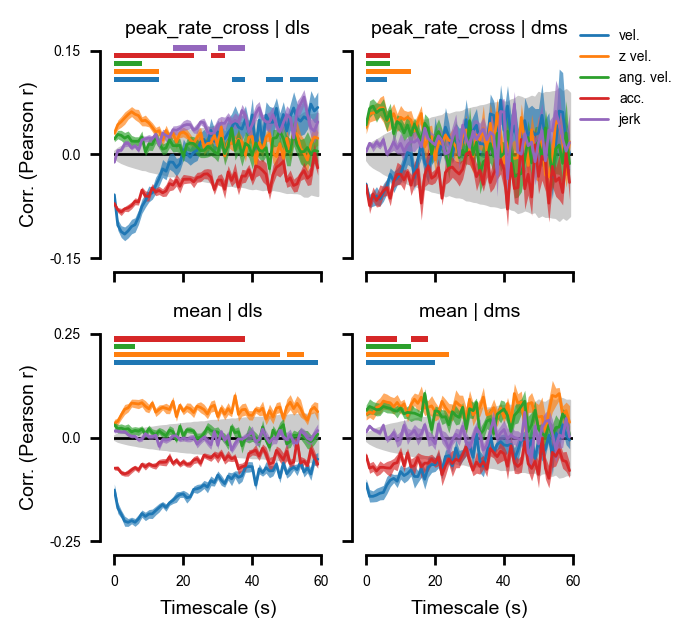

In [33]:
g = sns.relplot(
    data=corrs_plt.reset_index(),
    x="timescale",
    hue="variable",
    hue_order=plt_order,
    row="neural_agg",
    row_order=order,
    col="area",
    col_order=["dls", "dms"],
    y="value",
    height=1.6,
    aspect=0.65,
    ci=68,
    facet_kws={"sharey": "row"},
    # n_boot=0,
    err_kws={"alpha": 0.65, "ec": None, "lw": 0},
    kind="line",
)
g.set_axis_labels("Timescale (s)", "Corr. (Pearson r)")
g.set(xlim=(0, 60), ylim=(-0.25, 0.25))
g.set_titles(row_template="{row_name}", col_template="{col_name}")

plt.setp(g.axes[0], ylim=(-0.15, 0.15))
plt.setp(g.axes[1], ylim=(-0.25, 0.25))


l = g._legend
l.set_bbox_to_anchor((1.05, 0.75, 0.1, 0.25))
labels = l.get_texts()
for _label in labels:
    try:
        new_label = label_map[_label.get_text()]
        _label.set_text(new_label)
    except KeyError:
        pass

l.set_title("")

clean_ticks(g.axes[0, 0], "y", precision=2, zero_symmetry=False, eps=np.spacing(1.0))
clean_ticks(g.axes[1, 0], "y", precision=2, zero_symmetry=False, eps=np.spacing(1.0))

for ax in g.axes.flat:
    var, area = ax.get_title().split(" | ")
    ax.axhline(y=0, zorder=-200, color=plt.rcParams["axes.edgecolor"])
    use_chance = chance.xs((var, area), level=("neural_agg", "area"))
    ax.fill_between(
        use_chance.index,
        -use_chance.values,
        use_chance.values,
        zorder=-600,
        color=[0.8, 0.8, 0.8],
    )

    use_pval_df = pval_df.xs((var, area), level=("neural_agg", "area"))
    keys = plt_order
    key_level = "variable"
    use_colors = palette
    plot_pval(
        use_pval_df["value"],
        keys,
        key_level,
        ax=ax,
        colors=use_colors,
        offset=0.7,
        height=0.025,
        alpha_threshold=alpha_thresh,
        continuity_threshold=continuity_thresh,
    )

sns.despine(offset=5)
g.fig.tight_layout()
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], "fig1_dlight_scalar_correlations_pertimescale_lineplot"
    ),
    bbox_inches="tight",
)

In [34]:
import json

In [36]:
nmice = agg_data.groupby("area")["mouse_id"].nunique()
nsessions = agg_data.groupby("area")["uuid"].nunique()

In [37]:
agg_data.groupby("area")["uuid"].describe()

,count,unique,top,freq
area,,,,
dls,6541960,216,bd522604-480a-4999-b678-3b6fd7948c15,32028
dms,1884824,64,12a15de3-6b23-4187-ac44-7f10a2c293db,31292


In [38]:
with open(
    os.path.join(proc_dirs["dlight"], "stats_binned_scalars_correlation.toml"), "w"
) as f:
    plt_json = json.loads(pval_df.to_json())
    plt_json["stat_type"] = "Pearson correlation"
    plt_json["p_type"] = "Comparison to shuffle"
    for _area in ["dls", "dms"]:
        plt_json[f"n_mice_{_area}"] = nmice.loc[_area]
        plt_json[f"n_sessions_{_area}"] = nsessions.loc[_area]
    toml.dump(plt_json, f)

In [39]:
ave_corrs = (
    corrs_plt.dropna().groupby(["neural_agg", "area", "variable", "timescale"]).mean()
)
peak_locs = ave_corrs.groupby(ave_corrs.index.names[:-1])["value"].apply(
    lambda x: x.rolling(6, 1, True).mean().abs().idxmax()[-1]
)

In [40]:
peak_corrs = (
    corrs_plt.dropna()
    .groupby(["mouse_id", "neural_agg", "area", "variable"], observed=True)["value"]
    .apply(
        lambda x: x[
            x.index.get_level_values("timescale") == peak_locs.loc[x.name[1:]]
        ].iat[0]
    )
)

In [41]:
peak_corrs = peak_corrs.loc[
    peak_corrs.index.get_level_values("variable").isin(plt_order)
]

In [42]:
from scipy.stats import mannwhitneyu

In [43]:
use_test = mannwhitneyu

In [44]:
pvals = peak_corrs.groupby(["neural_agg", "variable"]).apply(
    lambda x: use_test(x.xs("dls", level="area"), x.xs("dms", level="area"))
)

In [45]:
n = peak_corrs.groupby(["neural_agg", "variable", "area"]).size().unstack()
n.columns = [f"n({_})" for _ in n.columns]

In [46]:
pvals = pvals.apply(pd.Series).rename(columns={0: "U", 1: "p"}).join(n)
pvals["test"] = use_test.__name__
pvals["tail"] = "two-tailed"
pvals["comparison"] = "per-mouse correlations"

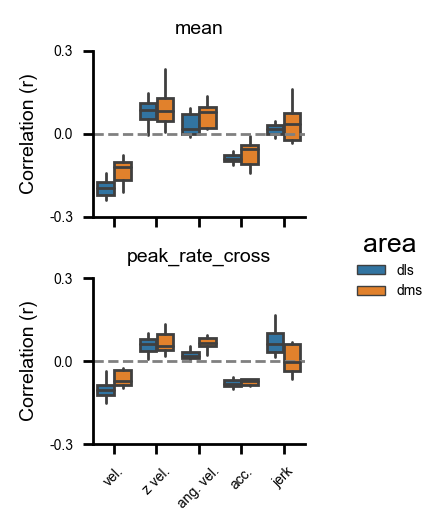

In [47]:
g = sns.catplot(
    data=peak_corrs.reset_index(),
    x="variable",
    order=plt_order,
    y="value",
    hue="area",
    height=1.25,
    aspect=1.4,
    # s=4,
    # alpha=.5,
    row="neural_agg",
    kind="box",
    showfliers=False,
    showcaps=False,
    dodge=True,
)
g.set_axis_labels("", "Correlation (r)")
g.refline(y=0)
g.set_titles(row_template="{row_name}")
clean_plot_labels(g.axes.flat[-1], label_map)
plt.xticks(rotation=45)

g.set(ylim=(-0.3, 0.3))
clean_ticks(g.axes.flat[0], "y", precision=2)
savefig(g.fig, os.path.join(figure_cfg["store_dir"], "dls_vs_dms_scalar_correlations"))

In [48]:
pvals["p"].values[:] = multipletests(pvals["p"].values, method="holm")[1]

In [49]:
import json

In [50]:
pvals["f"] = pvals["U"] / (pvals["n(dls)"] * pvals["n(dms)"])

In [51]:
with open(
    os.path.join(proc_dirs["dlight"], "dls_vs_dms_scalarcorrelations.toml"), "w"
) as f:
    toml.dump(json.loads(pvals.T.to_json()), f)